In [1]:
import h5py
import numpy as np
from synthesizer.conversions import lnu_to_absolute_mag
import pandas as pd
import unyt
from unyt import erg, Hz, s
import cmasher as cmr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
sys.path.append("/disk/xray15/aem2/camels/proj2")
from setup_params import get_photometry, get_luminosity_function, get_colour_distribution

# parameters
uvlf_limits = (-24, -16)
uvlf_nbins = 18
colour_limits = (-0.5, 3.5)
nbins_colour = 20

# magnitude limits (DIS) above from https://iopscience.iop.org/article/10.1086/520512/pdf
# NUV=24.4 mag
# FUV=24.8mag
NUV_mag_lim = 24.4
FUV_mag_lim = 24.8


In [4]:
# test first to check matches Chris.
# vcom and h doesnt need defining as hard coded in uvlf calc in setup_params.py

# specify the path to the photometry file for testing
input_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/photometry"
photo_file = "/disk/xray15/aem2/data/28pams/IllustrisTNG/photometry/IllustrisTNG_1P_p1_0_photometry.hdf5"

# load photometry data with GALEX filters
# see setup_params.py - this returns the AB magnitude in erg/s/Hz
filters = ["GALEX FUV", "GALEX NUV"]

photo_in = get_photometry(
    sim_name="1P_p1_0",
    spec_type="intrinsic",
    snap="086",
    sps="BC03",
    model="IllustrisTNG",
    filters=filters,
    photo_dir=input_dir
    )

print(photo_in.keys())
# calculate UV luminosity function (UVLF) for FUV and NUV

phi_FUV_in, phi_sigma_FUV_in, hist_FUV_in, bin_lims_FUV_in = get_luminosity_function(
    photo_in, "GALEX FUV", *uvlf_limits, n_bins=uvlf_nbins
)
phi_NUV_in, phi_sigma_NUV_in, hist_NUV_in, bin_lims_NUV_in = get_luminosity_function(
    photo_in, "GALEX NUV", *uvlf_limits, n_bins=uvlf_nbins
)

photo_att = get_photometry(
    sim_name="1P_p1_0",
    spec_type="attenuated",
    snap="044",
    sps="BC03",
    model="IllustrisTNG",
    filters=filters,
    photo_dir=input_dir
    )

# calculate UV luminosity function (UVLF) for FUV and NUV
phi_FUV_att, phi_sigma_FUV_att, hist_FUV_att, bin_lims_FUV_att = get_luminosity_function(
    photo_att, "GALEX FUV", *uvlf_limits, n_bins=uvlf_nbins
)
phi_NUV_att, phi_sigma_NUV_att, hist_NUV_att, bin_lims_NUV_att = get_luminosity_function(
    photo_att, "GALEX NUV", *uvlf_limits, n_bins=uvlf_nbins
)



dict_keys(['GALEX FUV', 'GALEX NUV'])


In [5]:
print(photo_in['GALEX FUV'])


[-19.81150562 -17.07353905 -14.46740957 ... -15.64613201  -8.70392497
  -8.97679498]


In [6]:
photo_in['GALEX FUV'].min()

-21.96054576865304

In [7]:
print(photo_in['GALEX NUV'])


[-20.19437517 -17.59589366 -15.80971859 ... -15.64991915 -11.20159378
 -11.39035799]


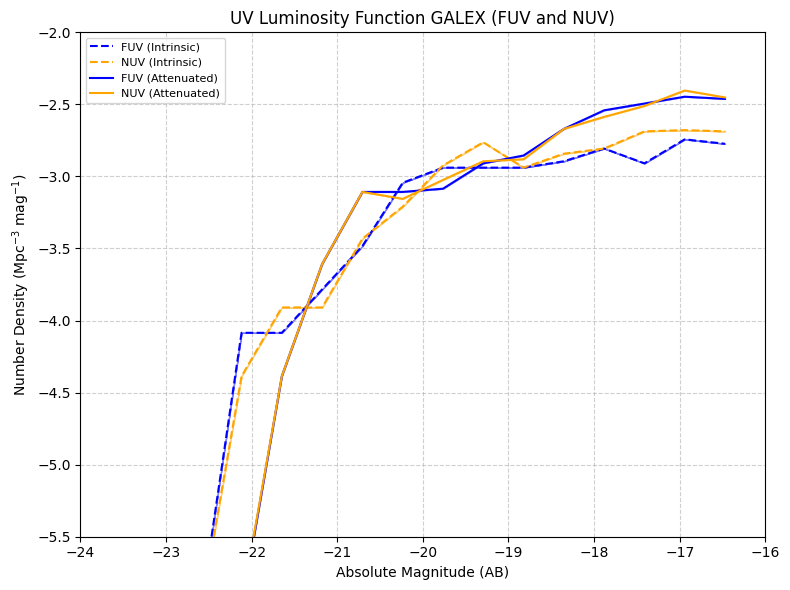

In [8]:
# plot UV luminosity function (UVLF) for GALEX FUV and NUV
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.grid(True, which='both', linestyle='--', alpha=0.6)

# INTRINSIC
# plot FUV UVLF
ax.plot(bin_lims_FUV_in[:-1], phi_FUV_in, label="FUV (Intrinsic)", color="blue", ls='--', zorder=2)
ax.fill_between(bin_lims_FUV_in[:-1], 
                phi_FUV_in - phi_sigma_FUV_in, 
                phi_FUV_in + phi_sigma_FUV_in, 
                color="blue", alpha=0.5, zorder=1)

# plot NUV UVLF
ax.plot(bin_lims_NUV_in[:-1], phi_NUV_in, label="NUV (Intrinsic)", color="orange", ls='--', zorder=2)
ax.fill_between(bin_lims_NUV_in[:-1], 
                phi_NUV_in - phi_sigma_NUV_in, 
                phi_NUV_in + phi_sigma_NUV_in, 
                color="orange", alpha=0.5, zorder=1)

# ATTENUATED
# plot FUV UVLF
ax.plot(bin_lims_FUV_att[:-1], phi_FUV_att, label="FUV (Attenuated)", color="blue", ls='-', zorder=2)
ax.fill_between(bin_lims_FUV_att[:-1], 
                phi_FUV_att - phi_sigma_FUV_att, 
                phi_FUV_att + phi_sigma_FUV_att, 
                color="blue", alpha=0.3, zorder=1)

# plot NUV UVLF
ax.plot(bin_lims_NUV_att[:-1], phi_NUV_att, label="NUV (Attenuated)", color="orange", ls='-', zorder=2)
ax.fill_between(bin_lims_NUV_att[:-1], 
                phi_NUV_att - phi_sigma_NUV_att, 
                phi_NUV_att + phi_sigma_NUV_att, 
                color="orange", alpha=0.3, zorder=1)

# set x and y lims
ax.set_xlim(-24,-16)
ax.set_ylim(-5.5,-2)

# add labels and title
ax.set_xlabel('Absolute Magnitude (AB)')
ax.set_ylabel('Number Density (Mpc$^{-3}$ mag$^{-1}$)')
ax.legend(loc='upper left', fontsize=8)
ax.set_title("UV Luminosity Function GALEX (FUV and NUV)")

plt.tight_layout()
plt.show()

In [9]:
fuv_mask = photo_in["GALEX FUV"] < FUV_mag_lim # Only include galaxies brighter than FUV=25
nuv_mask = photo_in["GALEX NUV"] < NUV_mag_lim # Only include galaxies brighter than NUV=25.3
combined_mask = fuv_mask & nuv_mask


In [10]:
# show how many galaxies make the cut
print(f"\nTotal galaxies: {len(photo_in['GALEX FUV'])}")
print(f"Galaxies after magnitude cuts: {np.sum(combined_mask)}")



Total galaxies: 1066
Galaxies after magnitude cuts: 1066


In [11]:
# check the full color range
test_color = photo_in["GALEX FUV"] - photo_in["GALEX NUV"]
print("Full color range in data:")
print(f"Min: {np.min(test_color)}")
print(f"Max: {np.max(test_color)}")

Full color range in data:
Min: -0.37612790767960647
Max: 3.3271137306041894


In [12]:
#get colour dist for fuv and nuv
 
colour_dist_in, bin_lims_colour_in = get_colour_distribution(
    photo=photo_in,
    filtA="GALEX FUV",
    filtB="GALEX NUV",
    lo_lim=-0.5,
    hi_lim=3.5,
    n_bins=20,
    mask=combined_mask  # apply our magnitude limit mask
)


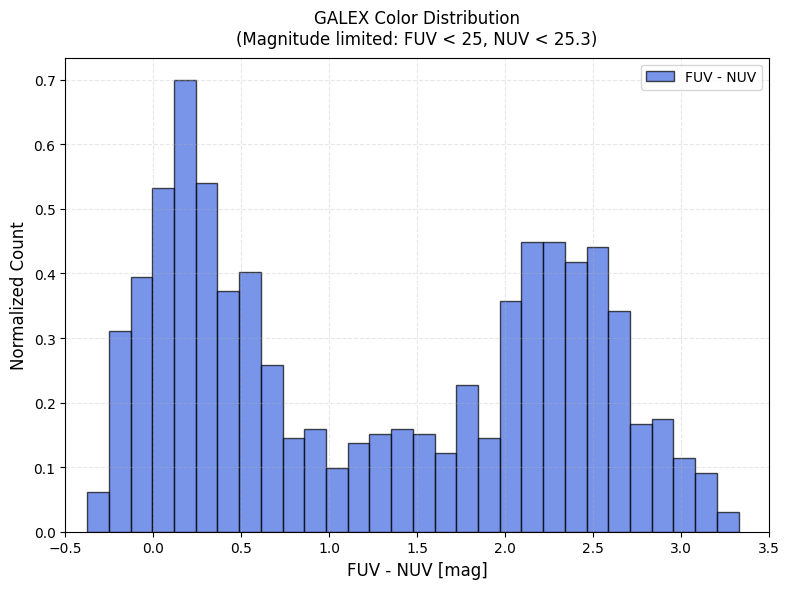

Number of galaxies after magnitude cuts: 1066
Mean color: 1.27
Median color: 1.20


In [13]:

# get colors for galaxies within magnitude limits
colors = photo_in["GALEX FUV"][combined_mask] - photo_in["GALEX NUV"][combined_mask]

fig, ax = plt.subplots(1, figsize=(8, 6))

# hist plot
ax.hist(colors, bins=30, density=True, alpha=0.7, color='royalblue', 
        edgecolor='black', linewidth=1, label='FUV - NUV')

ax.set_xlabel('FUV - NUV [mag]', fontsize=12)
ax.set_ylabel('Normalized Count', fontsize=12)
ax.set_title('GALEX Color Distribution\n(Magnitude limited: FUV < 25, NUV < 25.3)', 
             fontsize=12, pad=10)

ax.grid(True, linestyle='--', alpha=0.3)
ax.set_xlim(-0.5, 3.5)
ax.legend()

plt.tight_layout()
plt.show()

print(f"Number of galaxies after magnitude cuts: {len(colors)}")
print(f"Mean color: {np.mean(colors):.2f}")
print(f"Median color: {np.median(colors):.2f}")

In [14]:

#  test file details
sim_name = "1P_p1_0"
snap = "086"  # z=0.1
redshift = 0.1

# photometry using chris function
# note this gets photometry and puts into Absolute AB magnitudes already.
photo_in = get_photometry(
    sim_name=sim_name,
    spec_type="intrinsic",
    snap=snap,
    sps="BC03",
    model="IllustrisTNG",
    filters=["GALEX FUV", "GALEX NUV"],
    photo_dir=input_dir
)

phi_FUV, phi_sigma_FUV, hist_FUV, bin_limits_FUV = get_luminosity_function(
    photo_in, 
    "GALEX FUV", 
    *uvlf_limits, 
    n_bins=uvlf_nbins
)
phi_NUV, phi_sigma_NUV, hist_NUV, bin_limits_NUV = get_luminosity_function(
    photo_in, "GALEX NUV", *uvlf_limits, n_bins=uvlf_nbins
)



In [15]:
photo_in

{'GALEX FUV': array([-19.81150562, -17.07353905, -14.46740957, ..., -15.64613201,
         -8.70392497,  -8.97679498]),
 'GALEX NUV': array([-20.19437517, -17.59589366, -15.80971859, ..., -15.64991915,
        -11.20159378, -11.39035799])}

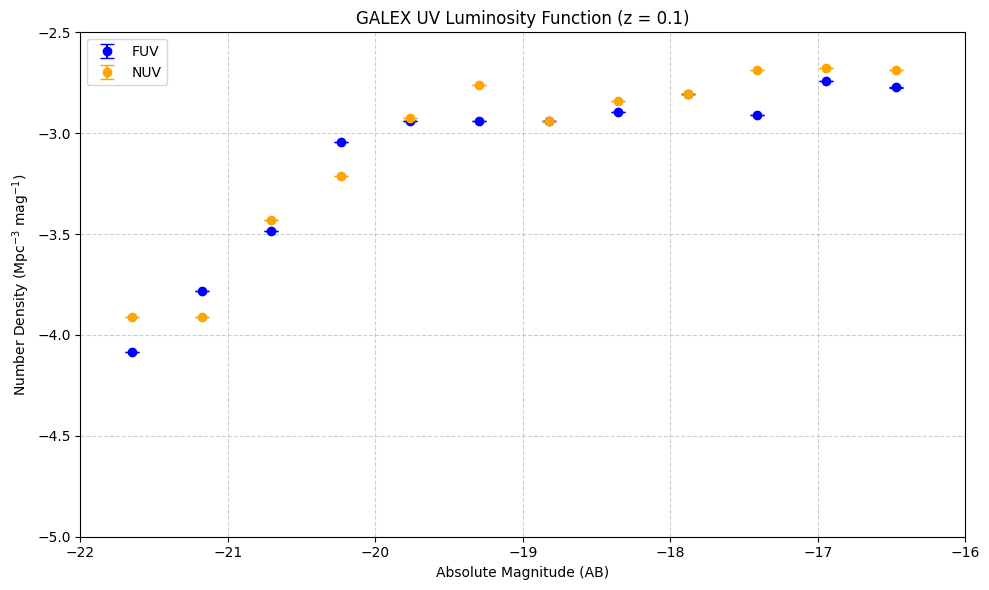


Number of galaxies:
FUV: 1066
NUV: 1066

Magnitude ranges:
FUV: -21.96 to -6.94
NUV: -21.84 to -9.18


In [16]:
plt.figure(figsize=(10, 6))
# fuv
plt.errorbar(bin_limits_FUV[:-1], phi_FUV, yerr=phi_sigma_FUV, 
            fmt='o', color='blue', label='FUV', capsize=5)
# nuv
plt.errorbar(bin_limits_NUV[:-1], phi_NUV, yerr=phi_sigma_NUV, 
            fmt='o', color='orange', label='NUV', capsize=5)

plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc$^{-3}$ mag$^{-1}$)')
#plt.yscale('log')
plt.title(f'GALEX UV Luminosity Function (z = {redshift})')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.xlim(-22,-16)
plt.ylim(-5, -2.5)

plt.tight_layout()
plt.show()

print(f"\nNumber of galaxies:")
print(f"FUV: {len(photo_in['GALEX FUV'])}")
print(f"NUV: {len(photo_in['GALEX NUV'])}")
print(f"\nMagnitude ranges:")
print(f"FUV: {photo_in['GALEX FUV'].min():.2f} to {photo_in['GALEX FUV'].max():.2f}")
print(f"NUV: {photo_in['GALEX NUV'].min():.2f} to {photo_in['GALEX NUV'].max():.2f}")

### this is the same plot as Chris paper, as a sanity check, everything looks solid and agrees:
### just reffering to the upper left plot (omega 0 fiducial) which is attenuated galex fuv at 0.1, same as above

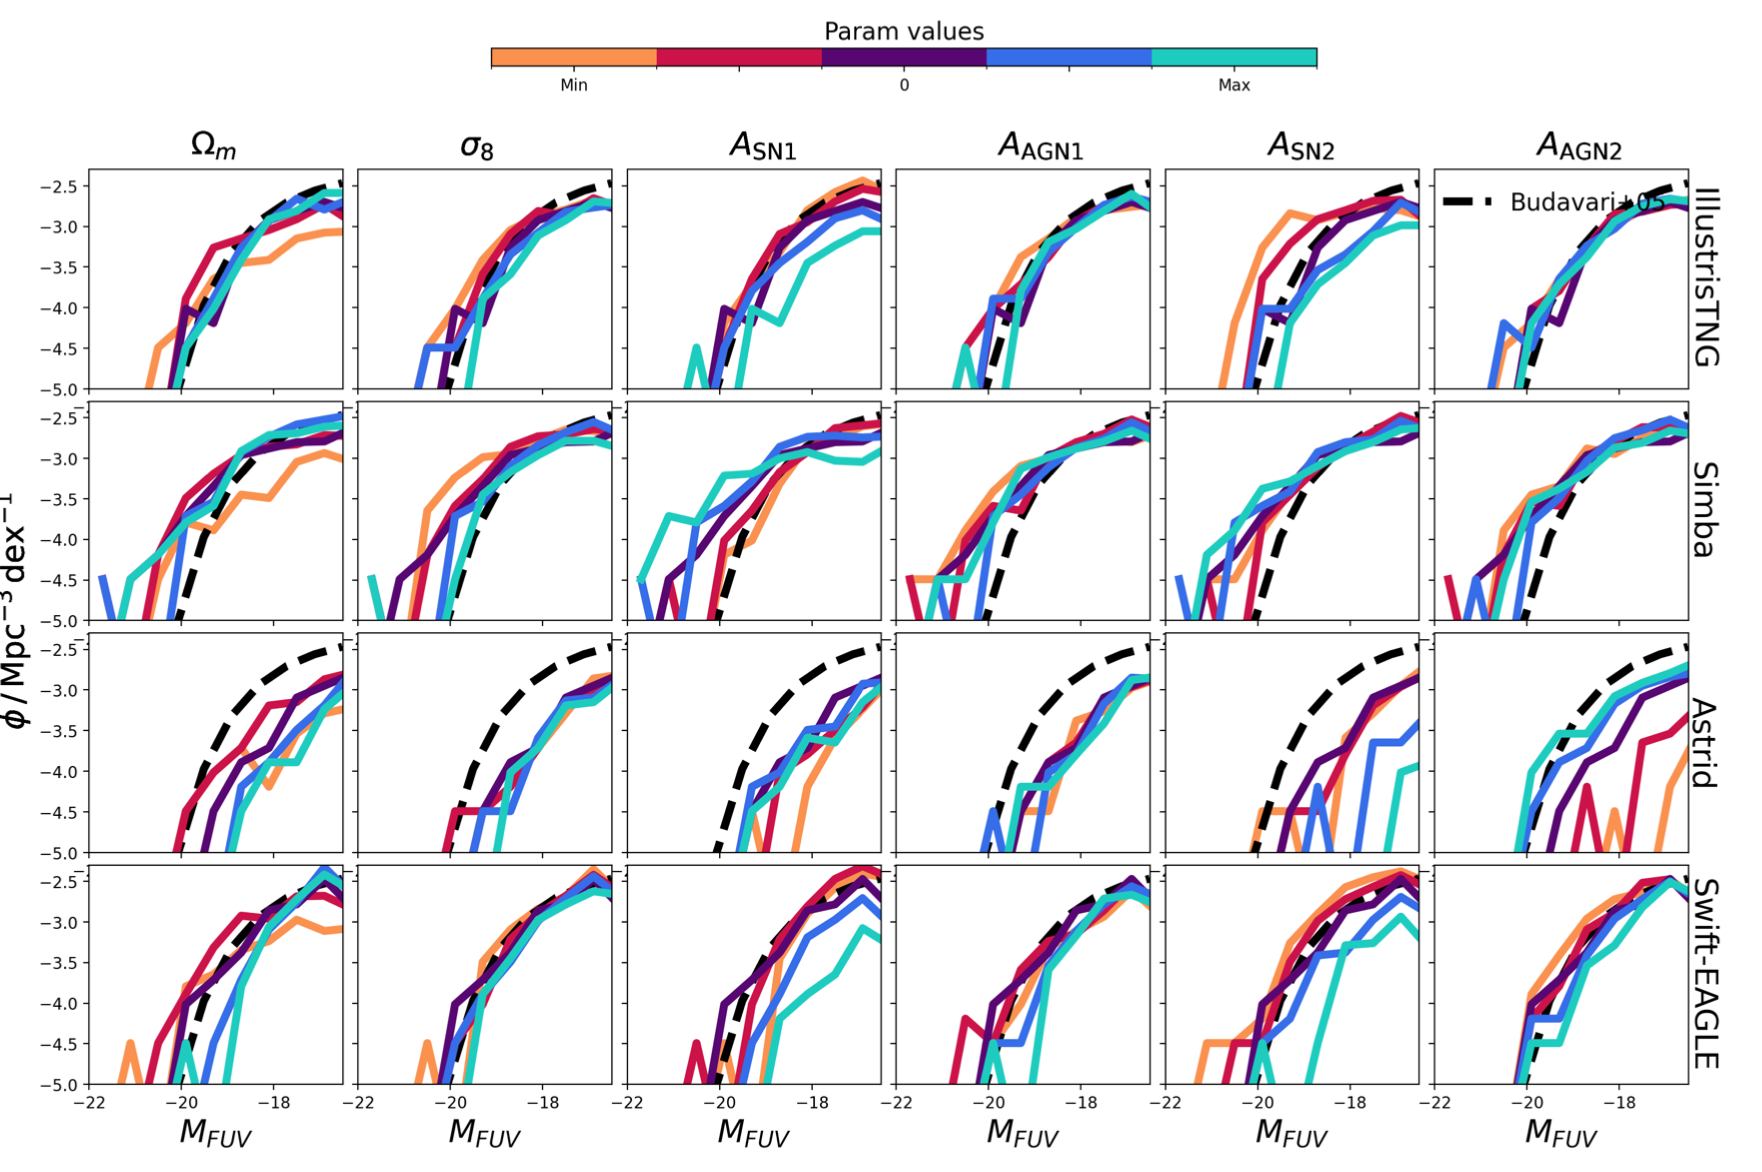

In [17]:
# but we actually want UVLF for intrinsic with GALEX and then the colours.

In [18]:
# First check what we're working with
print("Data type and units check:")
print("FUV type:", type(photo_in['GALEX FUV']))
print("FUV example value:", photo_in['GALEX FUV'][0])

# These are already in AB magnitudes (from lnu_to_absolute_mag in get_photometry)
# Now let's create magnitude limits mask for GALEX
fuv_mask = photo_in["GALEX FUV"] < 25.5  # FUV magnitude limit
nuv_mask = photo_in["GALEX NUV"] < 25.5  # NUV magnitude limit
combined_mask = fuv_mask & nuv_mask

# Calculate color distribution using the function from setup_params
colour_dist_in, bin_lims_colour_in = get_colour_distribution(
    photo=photo_in,
    filtA="GALEX FUV",
    filtB="GALEX NUV",
    lo_lim=-0.5,  # Based on typical FUV-NUV color ranges
    hi_lim=3.5,
    n_bins=20,
    mask=combined_mask
)

colour_dist_in

Data type and units check:
FUV type: <class 'numpy.ndarray'>
FUV example value: -19.811505621948424


array([0.02227955, 0.27626642, 0.494606  , 0.65056285, 0.40103189,
       0.27181051, 0.15150094, 0.10248593, 0.15150094, 0.16486867,
       0.15150094, 0.19160413, 0.47232645, 0.42776735, 0.34756098,
       0.27626642, 0.12476548, 0.06683865, 0.00445591])


Color statistics after magnitude cuts:
Number of galaxies: 1066
Mean FUV-NUV color: 1.27
Median FUV-NUV color: 1.20
Color range: -0.38 to 3.33


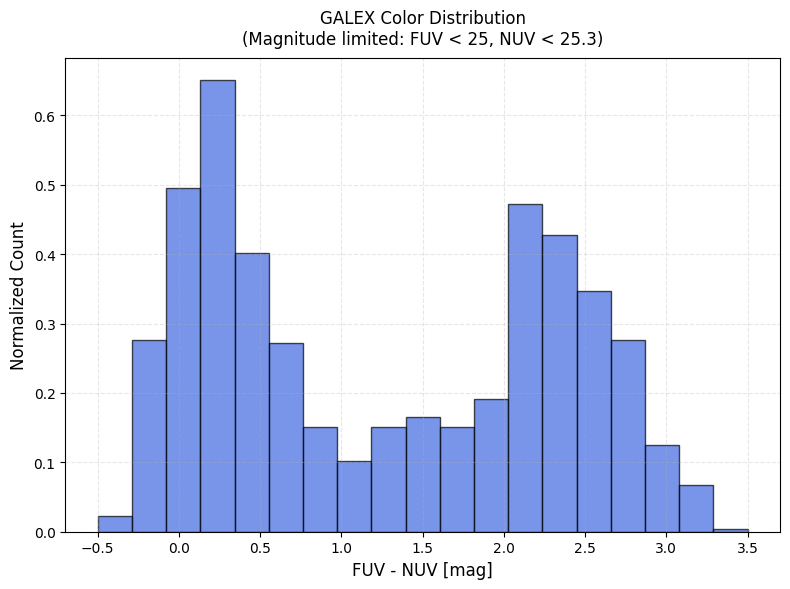

In [19]:
# Create histogram plot
fig, ax = plt.subplots(1, figsize=(8, 6))

# Calculate bin centers for plotting
mid_bins = 0.5 * (bin_lims_colour_in[:-1] + bin_lims_colour_in[1:])

# Plot color distribution
ax.hist(photo_in["GALEX FUV"][combined_mask] - photo_in["GALEX NUV"][combined_mask], 
        bins=bin_lims_colour_in, density=True, alpha=0.7, color='royalblue',
        edgecolor='black', linewidth=1)

# Customize plot
ax.set_xlabel('FUV - NUV [mag]', fontsize=12)
ax.set_ylabel('Normalized Count', fontsize=12)
ax.set_title('GALEX Color Distribution\n(Magnitude limited: FUV < 25, NUV < 25.3)', 
             fontsize=12, pad=10)
ax.grid(True, linestyle='--', alpha=0.3)

# Print some statistics
colors = photo_in["GALEX FUV"][combined_mask] - photo_in["GALEX NUV"][combined_mask]
print("\nColor statistics after magnitude cuts:")
print(f"Number of galaxies: {len(colors)}")
print(f"Mean FUV-NUV color: {np.mean(colors):.2f}")
print(f"Median FUV-NUV color: {np.median(colors):.2f}")
print(f"Color range: {np.min(colors):.2f} to {np.max(colors):.2f}")

plt.tight_layout()
plt.show()